 # Приложение 1.

In [1]:
import numpy as np
from time import time
import math
import copy

from random import randint
from scipy.sparse import rand

from scipy.sparse.linalg import cg

from scipy.sparse import random
from scipy.stats import rv_continuous
from scipy.sparse import random
from scipy import stats
from numpy.random import default_rng

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.set_printoptions(precision=5, suppress=True)

In [3]:
class SparseVector:
    def __init__(self, n, v=None):
        self.n = n
        print(v)
        self.keys = {} if v is None else v

    def shape(self):
        return self.n

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        if i in self.keys:
            return self.keys[i]
        else:
            return 0

    def __setitem__(self, i, val):
        self.keys[i] = val

    def __str__(self):
        __str = '['
        for i in range(self.n):
            if i in self.keys:
                __str += str(self.keys[i]) + ', '
            else:
                __str += '0, '
        __str += ']\n'
        return __str

    def __rmul__(self, other):
        if not (isinstance(other, float) or isinstance(other, int)):
            raise RuntimeError("not instance")
        res = SparseVector(self.n)
        for i in range(self.n):
            if i in self.keys:
                res[i] = self[i] * other
        return res

    def __mul__(self, other):
        if not (isinstance(other, float) or isinstance(other, int)):
            raise RuntimeError("not instance")
        res = SparseVector(self.n)
        for i in range(self.n):
            if i in self.keys:
                res[i] = self[i] * other
        return res

    def __add__(self, other):
        if self.n != other.n:
            raise RuntimeError("n != n\n")
        res = SparseVector(self.n)
        for i in range(self.n):
            if i in self.keys or i in other.keys:
                res[i] = self[i] + other[i]
        return res

    def __sub__(self, other):
        if self.n != other.n:
            raise RuntimeError("n != n\n")
        res = SparseVector(self.n)
        for i in range(self.n):
            if i in self.keys or i in other.keys:
                res[i] = self[i] - other[i]
        return res

    def __matmul__(self, other):
        if not isinstance(other, SparseVector):
            raise RuntimeError("not instance")
        if self.n != other.n:
            raise RuntimeError("n != n\n")
        res = 0.0
        for i in range(self.n):
            if i in self.keys and i in other.keys:
                res += self[i] * other[i]
        return res

In [4]:
class SparseMatrix:
    def __init__(self, n, m, v=None):
        self.n = n
        self.m = m
        self.shape = (n, m)
        self.keys = {} if v is None else v

    def __len__(self):
        return self.n * self.m

    def __getitem__(self, index):
        if index in self.keys:
            return self.keys[index]
        else:
            return 0

    def __setitem__(self, index, val):
        self.keys[index] = val

    def __str__(self):
        __str = '[\n'
        for i in range(self.n):
            for j in range(self.m):
                if (i, j) in self.keys:
                    __str += str(self.keys[i, j]) + ', '
                else:
                    __str += '0, '
            __str += '\n'
        __str += ']\n'
        return __str

    def T(self):
        res = SparseMatrix(self.m, self.n)
        for i in range(self.n):
            for j in range(self.m):
                if (i, j) in self.keys:
                    res.keys[j, i] = self.keys[i, j]
        return res

    def normL2(self):
        if self.m != 1:
            raise RuntimeError("no compute")
        res = 0.0
        for i in range(self.n):
            if (i, 0) in self.keys:
                res += self.keys[i, 0] * self.keys[i, 0]
        return res**0.5

    def normC(self):
        maxi = float('-inf')
        if self.m == 1:
            for i in range(self.shape[0]):
                maxi = max(abs(self[i, 0]), maxi)
        else:
            for i in range(self.shape[0]):
                maxsum = 0
                for j in range(self.shape[1]):
                    maxsum += abs(self[i, j])
                maxi = max(maxsum, maxi)
        return maxi

    def numpy(self):
        res = []
        for i in range(self.n):
            tmp = []
            for j in range(self.m):
                tmp.append(self[i, j])
            res.append(tmp)
        return np.array(res)

    def round(self, d):
        res = SparseMatrix(self.n, self.m)
        for i in range(self.n):
            for j in range(self.m):
                if (i, j) in self.keys:
                    res[i, j] = round(self[i, j], d)
        return res

    def __matmul__(self, other):
        res = SparseMatrix(self.n, other.shape[1])
        for i in range(self.n):
            for j in range(other.shape[1]):
                dot_value = 0
                for p in range(self.m):
                    if (i, p) in self.keys and (p, j) in other.keys:
                        dot_value += self.keys[i, p] * other.keys[p, j]
                if dot_value != 0:
                    res.keys[i, j] = dot_value
        if self.n == other.shape[1] == 1:
            return float(res[0, 0])
        return res

    def __add__(self, other):
        if not isinstance(other, SparseMatrix):
            raise RuntimeError("not instance")
        res = SparseMatrix(self.n, self.m)
        for i in range(self.n):
            for j in range(self.m):
                if (i, j) in self.keys or (i, j) in other.keys:
                    res[i, j] = self[i, j] + other[i, j]
        return res

    def __sub__(self, other):
        if not isinstance(other, SparseMatrix):
            raise RuntimeError("not instance")
        res = SparseMatrix(self.n, self.m)
        for i in range(self.n):
            for j in range(self.m):
                if (i, j) in self.keys or (i, j) in other.keys:
                    res[i, j] = self[i, j] - other[i, j]
        return res

    def __sub__(self, other):
        if not isinstance(other, SparseMatrix):
            raise RuntimeError("not instance")
        res = SparseMatrix(self.n, self.m)
        for i in range(self.n):
            for j in range(self.m):
                if (i, j) in self.keys or (i, j) in other.keys:
                    res[i, j] = self[i, j] - other[i, j]
        return res

    def __rmul__(self, val):
        if not (isinstance(val, float) or isinstance(val, int)):
            raise RuntimeError("not int or float")
        res = SparseMatrix(self.n, self.m)
        for i in range(self.n):
            for j in range(self.m):
                if (i, j) in self.keys:
                    res[i, j] = val * self[i, j]
        return res

    def __mul__(self, val):
        if not (isinstance(val, float) or isinstance(val, int)):
            raise RuntimeError("not int or float")
        res = SparseMatrix(self.n, self.m)
        for i in range(self.n):
            for j in range(self.m):
                if (i, j) in self.keys:
                    res[i, j] = val * self[i, j]
        return res

In [5]:
def iterations(A, b, eps=1e-9):
    n = A.shape[0]
    beta = SparseMatrix(n, 1)
    for i in range(n):
        beta[i, 0] = b[i, 0] / A[i, i]
    alpha = SparseMatrix(n, A.shape[1])
    for i in range(n):
        for j in range(n):
            alpha[i, j] = -A[i, j] / A[i, i]
        alpha[i, i] = 0
    x = copy.deepcopy(beta)
    xprev = SparseMatrix(n, 1)
    q = alpha.normC()
    iters = 0
    while ((xprev - x).normC() > eps):
        xprev = x
        x = beta + alpha @ xprev
        iters += 1
    return x, iters

In [6]:
def Zeidel(A, b, eps=1e-9):
    n = A.shape[0]
    beta = SparseMatrix(n, 1)
    for i in range(n):
        beta[i, 0] = b[i, 0] / A[i, i]
    alpha = SparseMatrix(n, A.shape[1])
    for i in range(n):
        for j in range(n):
            alpha[i, j] = -A[i, j] / A[i, i]
        alpha[i, i] = 0
    x = copy.deepcopy(beta)
    xprev = SparseMatrix(n, 1)
    q = alpha.normC()
    iters = 0
    while ((xprev - x).normC() > eps):
        xprev = copy.deepcopy(x)
        for i in range(n):
            x[i, 0] = beta[i, 0] + sum(alpha[i, j] * x[j, 0] for j in range(0, i)) + sum(alpha[i, j] * xprev[j, 0] for j in range(i, n))
        iters += 1
    return x, iters

In [7]:
class CG:
    def __init__(self, A, b, x0=None, eps=1e-7, max_iter=1000):
        self.A = A
        self.b = b
        self.eps = eps
        self.max_iter = max_iter
        self.shape = A.shape[0]
        self.x0 = SparseMatrix(self.shape, 1) if x0 is None else x0
        self.k = 0

    def solve(self):
        x0 = self.x0
        r0 = self.b - (self.A @ x0)
        p1 = r0
        # p1 = copy(r0) # !!!
        for _ in range(self.max_iter):
            z = self.A @ p1
            nu1 = (r0.T() @ r0) / (p1.T() @ z)
            x1 = x0 + p1 * nu1
            r1 = r0 - z * nu1
            mu2 = (r1.T() @ r1) / (r0.T() @ r0)
            p2 = r1 + mu2 * p1
            r0 = r1
            p1 = p2
            x0 = x1
            self.k += 1
            if r1.normL2() < self.eps:
                break
        return x0

    def print_result(self, show=True):
        start = time()
        x = self.solve()
        end = time()
        start_1 = time()
        x_1, iter_1 = iterations(self.A, self.b)
        end_1 = time()
        start_2 = time()
        x_2, iter_2 = Zeidel(self.A, self.b)
        end_2 = time()
        start2 = time()
        x2 = np.linalg.solve(self.A.numpy(), self.b.numpy())
        end2 = time()
        start3 = time()
        x3, _ = cg(self.A.numpy(), self.b.numpy(), tol=1e-9)
        end3 = time()
        if show is True:
            print('CG custom:')
            if self.A.shape[0] < 20:
                print(f'{np.squeeze(x.round(5).numpy())}\n')
            print(f'eps={self.eps} shape={self.shape} iterations={self.k} time={round(end - start, 5)} seconds\n')
            print('\nIterations custom:')
            if self.A.shape[0] < 20:
                print(f'{np.squeeze(x_1.round(5).numpy())}\n')
            print(f'eps={self.eps} shape={self.shape} iterations={iter_1} time={round(end - start, 5)} seconds\n')
            print('\nZeidel custom:')
            if self.A.shape[0] < 20:
                print(f'{np.squeeze(x_2.round(5).numpy())}\n')
            print(f'eps={self.eps} shape={self.shape} iterations={iter_2} time={round(end - start, 5)} seconds\n')
            print('\nNumPy linalg:')
            if self.A.shape[0] < 20:
                print(f'{np.squeeze(x2.round(5))}\n')
            print(f'time={round(end2 - start2, 5)} seconds\n')
            print('\nSciPy CG:')
            if self.A.shape[0] < 20:
                print(f'{x3.round(5)}\n')
            print(f'time={round(end3 - start3, 5)} seconds\n')
            print(f'\nErrors:')
            print(f'error CG vs Iterations: {np.max(np.abs(np.squeeze(x.numpy()) - np.squeeze(x_1.numpy())))}')
            print(f'error CG vs Zeidel: {np.max(np.abs(np.squeeze(x.numpy()) - np.squeeze(x_2.numpy())))}')
            print(f'error CG vs NumPy: {np.max(np.abs(np.squeeze(x.numpy()) - np.squeeze(x2)))}')
            print(f'error CG vs SciPy: {np.max(np.abs(np.squeeze(x.numpy()) - np.squeeze(x3)))}')
        return (end - start,
                end_1 - start_1,
                end_2 - start_2,
                end2 - start2,
                end3 - start3), (self.k, iter_1, iter_2), (
                   0, np.max(np.abs(np.squeeze(x.numpy()) - np.squeeze(x_1.numpy()))),
                   np.max(np.abs(np.squeeze(x.numpy()) - np.squeeze(x_2.numpy()))),
                   np.max(np.abs(np.squeeze(x.numpy()) - np.squeeze(x2))),
                   np.max(np.abs(np.squeeze(x.numpy()) - np.squeeze(x3)))
               )

In [8]:
output = "matrix.txt"
shape = int(input())
rng = default_rng()
class CustomDistribution(rv_continuous):
    def _rvs(self,  size=None, random_state=None):
        return random_state.standard_normal(size)
X = CustomDistribution(seed=rng)
Y = X()
matrix = random(shape, shape, density=0.1, random_state=rng, data_rvs=Y.rvs)

matrix = matrix.toarray()
for i in range(shape):
    for j in range(shape):
        matrix[j][i] = matrix[i][j]
        if i == j:
            matrix[i][j] = 100.0
with open(output, "w") as f:
    f.write(f"{shape}\n")
    for i in matrix.round(3):
        for j in i:
            f.write(f"{j} ")
        f.write("\n")
    d = np.random.randint(0, 100, shape)
    for i in d:
        f.write(f"{i} ")
    f.write("\n")

 10


In [9]:
def read_matrix(filename: str):
    with open(filename) as f:
        shape = int(f.readline())
        _A = [[float(num) for num in line.split()]
                  for _, line in zip(range(shape), f)]
        A = SparseMatrix(shape, shape)
        for i in range(shape):
            for j in range(shape):
                if _A[i][j] != 0.0:
                    A[i, j] = _A[i][j]
        _b = [float(num) for num in f.readline().split()]
        b = SparseMatrix(shape, 1)
        for i in range(shape):
            if _b[i] != 0.0:
                b[i, 0] = _b[i]
        return A, b

In [10]:
AA, bb = read_matrix("matrix.txt")

In [11]:
solver = CG(AA, bb)
solver.print_result()

CG custom:
[0.97714 0.16913 0.97    0.48363 0.44955 0.06996 0.331   0.25    0.81
 0.90953]

eps=1e-07 shape=10 iterations=5 time=0.00176 seconds


Iterations custom:
[0.97714 0.16913 0.97    0.48363 0.44955 0.06996 0.331   0.25    0.81
 0.90953]

eps=1e-07 shape=10 iterations=6 time=0.00176 seconds


Zeidel custom:
[0.97714 0.16913 0.97    0.48363 0.44955 0.06996 0.331   0.25    0.81
 0.90953]

eps=1e-07 shape=10 iterations=5 time=0.00176 seconds


NumPy linalg:
[0.97714 0.16913 0.97    0.48363 0.44955 0.06996 0.331   0.25    0.81
 0.90953]

time=0.00037 seconds


SciPy CG:
[0.97714 0.16913 0.97    0.48363 0.44955 0.06996 0.331   0.25    0.81
 0.90953]

time=0.00122 seconds


Errors:
error CG vs Iterations: 8.698705644683002e-11
error CG vs Zeidel: 8.695366648936442e-11
error CG vs NumPy: 8.695349995591073e-11
error CG vs SciPy: 0.0


((0.001756429672241211,
  0.00171661376953125,
  0.0021827220916748047,
  0.0003724098205566406,
  0.0012199878692626953),
 (5, 6, 5),
 (0, 8.698705644683002e-11, 8.695366648936442e-11, 8.695349995591073e-11, 0.0))

In [12]:
def plots():
    cgr = []
    iter = []
    zeidel = []
    numpy = []
    scipy = []
    cgr_iter = []
    iter_iter = []
    zeidel_iter = []
    sizes = [2**i for i in range(2, 12)]
    for shape in sizes:
        output = "matrix.txt"
        rng = default_rng()
        class CustomDistribution(rv_continuous):
            def _rvs(self,  size=None, random_state=None):
                return random_state.standard_normal(size)
        X = CustomDistribution(seed=rng)
        Y = X()
        matrix = random(shape, shape, density=0.3, random_state=rng, data_rvs=Y.rvs)
        
        matrix = matrix.toarray()
        for i in range(shape):
            for j in range(shape):
                matrix[j][i] = matrix[i][j]
                if i == j:
                    matrix[i][j] = 100.0
        with open(output, "w") as f:
            f.write(f"{shape}\n")
            for i in matrix.round(3):
                for j in i:
                    f.write(f"{j} ")
                f.write("\n")
            d = np.random.randint(0, 100, shape)
            for i in d:
                f.write(f"{i} ")
            f.write("\n")
        AA, bb = read_matrix("matrix.txt")
        solver = CG(AA, bb)
        times, iters, _ = solver.print_result(show=False)
        cgr.append(times[0])
        iter.append(times[1])
        zeidel.append(times[2])
        numpy.append(times[3])
        scipy.append(times[4])
        cgr_iter.append(iters[0])
        iter_iter.append(iters[1])
        zeidel_iter.append(iters[2])
    plt.figure(figsize=(12, 6))
    plt.plot(sizes, cgr)
    plt.plot(sizes, iter)
    plt.plot(sizes, zeidel)
    plt.plot(sizes, numpy)
    plt.plot(sizes, scipy)
    plt.legend(["Метод сопряжённых градиентов", 
                "Метод простых итераций",
                "Метод Зейделя",
                "numpy.linalg",
                "scipy.cg"])
    plt.title("Время работы")
    plt.xlabel("Порядок матрицы")
    plt.ylabel("Время (с)")
    plt.grid(True)
    plt.show()
    plt.figure(figsize=(12, 6))
    plt.plot(sizes, cgr_iter)
    plt.plot(sizes, iter_iter)
    plt.plot(sizes, zeidel_iter)
    plt.legend(["Метод сопряжённых градиентов", 
                "Метод простых итераций",
                "Метод Зейделя"])
    plt.title("Количество итераций")
    plt.xlabel("Порядок матрицы")
    plt.ylabel("Количество итераций")
    plt.grid(True)
    plt.show()

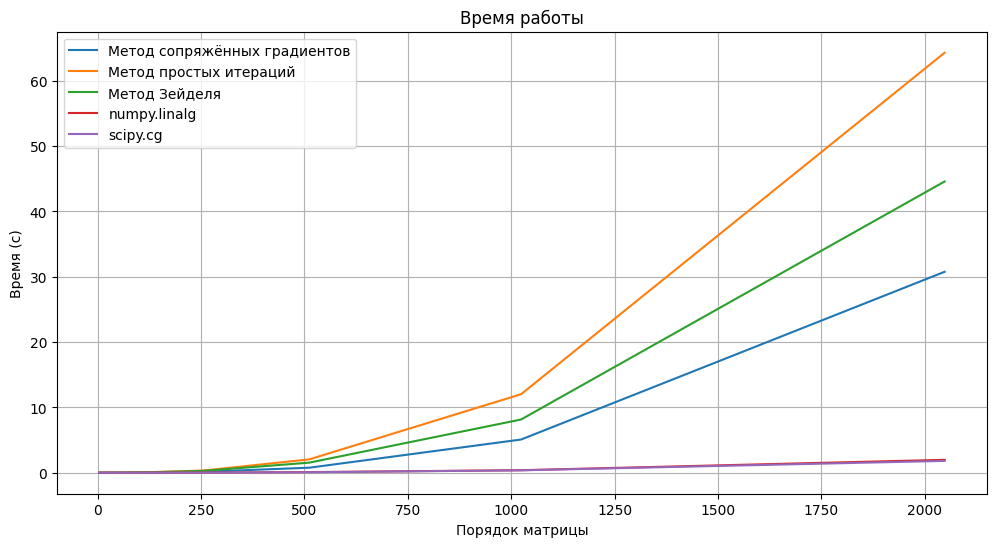

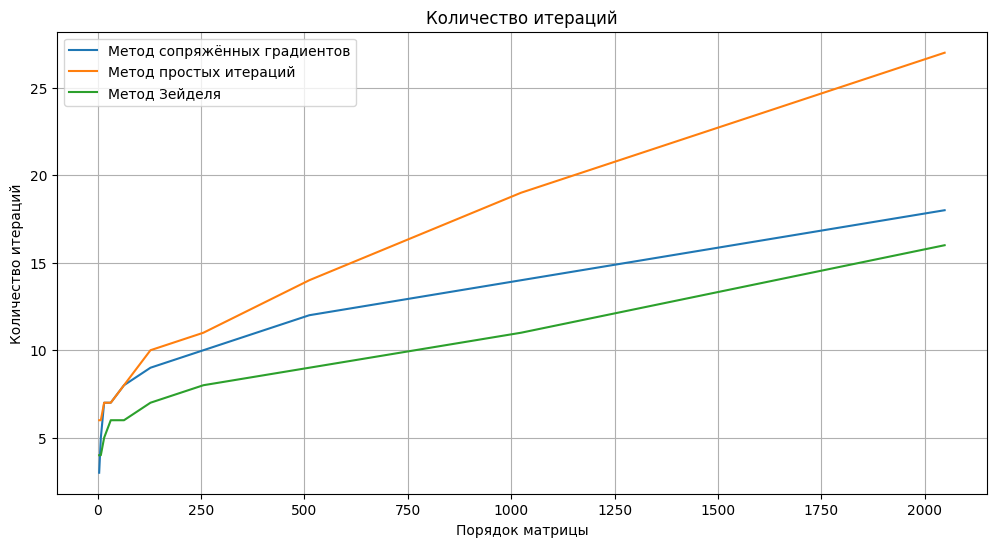

In [13]:
plots()

In [14]:
# Mini-tests

In [15]:
def plots_err(a, b):
    iter = []
    zeidel = []
    numpy = []
    scipy = []
    sizes = [2**i for i in range(a, b)]
    for shape in sizes:
        output = "matrix.txt"
        rng = default_rng()
        class CustomDistribution(rv_continuous):
            def _rvs(self,  size=None, random_state=None):
                return random_state.standard_normal(size)
        X = CustomDistribution(seed=rng)
        Y = X()
        matrix = random(shape, shape, density=0.3, random_state=rng, data_rvs=Y.rvs)
        
        matrix = matrix.toarray()
        for i in range(shape):
            for j in range(shape):
                matrix[j][i] = matrix[i][j]
                if i == j:
                    matrix[i][j] = 100.0
        with open(output, "w") as f:
            f.write(f"{shape}\n")
            for i in matrix.round(3):
                for j in i:
                    f.write(f"{j} ")
                f.write("\n")
            d = np.random.randint(0, 100, shape)
            for i in d:
                f.write(f"{i} ")
            f.write("\n")
        AA, bb = read_matrix("matrix.txt")
        solver = CG(AA, bb)
        _, _, err = solver.print_result(show=False)
        iter.append(err[1])
        zeidel.append(err[2])
        numpy.append(err[3])
        scipy.append(err[4])
    plt.figure(figsize=(12, 6))
    plt.plot(sizes, iter)
    plt.plot(sizes, zeidel)
    plt.plot(sizes, numpy)
    plt.plot(sizes, scipy)
    plt.legend(["Метод простых итераций",
                "Метод Зейделя",
                "numpy.linalg", 
                "scipy.cg"])
    plt.title("Ошибка")
    plt.xlabel("Порядок матрицы")
    plt.ylabel("Значение ошибки")
    plt.grid(True)
    plt.show()

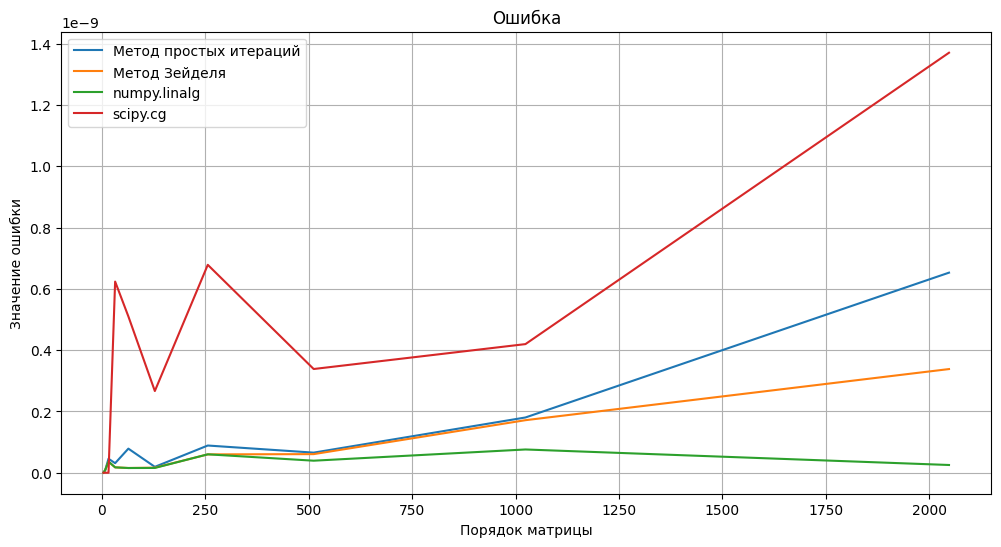

In [20]:
plots_err(2, 12)

In [18]:
import numpy as np

def read_sparse_A(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    num_rows, num_cols = map(int, lines[0].split())
    A = SparseMatrix(num_rows, num_cols)
    for line in lines[1:]:
        i, j, value = map(float, line.split())
        A[int(i), int(j)] = value
    return A

def read_sparse_b(filename):
    with open(filename, 'r') as file:
        values = [float(value) for value in file.read().split()]
    A = SparseMatrix(len(values), 1)
    for i, value in enumerate(values):
        A[i, 0] = value
    return A

A_filename = 'A.txt'
vector_filename = 'b.txt'

sparse_A = read_sparse_A(A_filename)
sparse_b = read_sparse_b(vector_filename)

print("Sparse A:")
print(sparse_A)

print("\nSparse b:")
print(sparse_b)

Sparse A:
[
1.0, 0, 0, 0, 
0, 2.0, 0, 0, 
0, 0, 3.0, 0, 
0, 0, 0, 4.0, 
]


Sparse b:
[
10.0, 
20.0, 
30.0, 
40.0, 
]



In [19]:
solver = CG(sparse_A, sparse_b)
solver.print_result()

CG custom:
[10. 10. 10. 10.]

eps=1e-07 shape=4 iterations=4 time=0.00021 seconds


Iterations custom:
[10. 10. 10. 10.]

eps=1e-07 shape=4 iterations=1 time=0.00021 seconds


Zeidel custom:
[10. 10. 10. 10.]

eps=1e-07 shape=4 iterations=1 time=0.00021 seconds


NumPy linalg:
[10. 10. 10. 10.]

time=9e-05 seconds


SciPy CG:
[10. 10. 10. 10.]

time=0.00026 seconds


Errors:
error CG vs Iterations: 1.7763568394002505e-15
error CG vs Zeidel: 1.7763568394002505e-15
error CG vs NumPy: 1.7763568394002505e-15
error CG vs SciPy: 0.0


((0.00020956993103027344,
  0.00010061264038085938,
  8.96453857421875e-05,
  8.678436279296875e-05,
  0.00026035308837890625),
 (4, 1, 1),
 (0,
  1.7763568394002505e-15,
  1.7763568394002505e-15,
  1.7763568394002505e-15,
  0.0))